<br/>

$$ \huge{\underline{\textbf{ Playing Atari Games with Deep RL }}} $$

$$ \large{\textbf{MountainCar + DQN + Memory Reply}} $$

<br/>



In [3]:
def q_learning(env, frames, gamma, eps_decay_steps, eps_target, action_repeat,
               batch_size, model, mem, callback=None, trace=None):
    """Episodic Semi-Gradient Sarsa
    
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        eps - epsilon-greedy param
        model      - function approximator, already initialised, with methods:
                     eval(state, action) -> float
                     train(state, target) -> None
    """
    def policy(st, model, eps):
        if np.random.rand() > eps:
            q_values = model.eval(np.array([st]))
            return np.argmax(q_values)
        else:
            return env.action_space.sample()
    
    if eps_decay_steps is not None:
        eps_delta = (1-eps_target) / eps_decay_steps
        eps = 1
    else:
        eps = eps_target
        
    # Fill memory buffer using random policy
    while len(mem) < mem.max_len:
        S = env.reset();
        for t_ in itertools.count():
            if t_ % action_repeat == 0:
                A = env.action_space.sample()    # random policy
            S_, R, done, _ = env.step(A)
            mem.append(S, A, R, S_, done)
            if done:
                break
            S = S_

    tts_ = 0                                 # total time step
    for e_ in itertools.count():             # count from 0 to infinity
        
        S = env.reset()
        
        for t_ in itertools.count():         # count from 0 to infinity
            
            if t_ % action_repeat == 0:
                A = policy(S, model, eps)
            
            S_, R, done, _ = env.step(A)
            
            mem.append(S, A, R, S_, done)
            
            if callback is not None:
                callback(e_, t_, S, A, R, done, eps, model, mem, trace)
            
            states, actions, rewards, n_states, dones, _ = mem.get_batch(batch_size)
            targets = model.eval(n_states)
            targets = rewards + gamma * np.max(targets, axis=-1)
            targets[dones] = rewards[dones]                # return of next-to-terminal state is just R
            model.train(states, actions, targets)

            if done:
                break
                
            if tts_ >= frames:
                return
                
            S = S_
            
            if eps > eps_target:
                eps = max(eps - eps_delta, eps_target)
                
            tts_ += 1

In [4]:
# def test_car(env, ep, model, callback=None, trace=None):

#     def policy(st, model):
#         q_values = model.eval([st])
#         return argmax_rand(q_values)
    
#     for e_ in range(ep):
        
#         S = env.reset()
        
        
#         for t_ in range(1000):       
        
#             A = policy(S, model)
#             S_, R, done, _ = env.step(A)
            
#             if callback is not None:
#                 if t_ == 999:  done=True
#                 callback(e_, t_, S, A, R, done, 0, model, None, trace)
            
#             if done:
#                 break
                
#             S = S_

Tile Coding - see [chapter 9.5](0905b_LM_Agg_Tile.ipynb) for introduction

---

# Experiment Setup

Imports (source file: [tiles3.py](tiles3.py), [helpers_1001.py](helpers_1001.py))

In [5]:
import pdb

In [6]:
import time
import numpy as np
import matplotlib.pyplot as plt
import itertools
import collections

import gym
import tensorflow as tf

Environment

In [24]:
import helpers
import importlib
importlib.reload(helpers)

<module 'helpers' from '/home/marcin/ai_sketchpad/Deep_Q_Network/helpers.py'>

In [12]:
env = gym.make('MountainCar-v0').env

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [28]:
class PendulumEnv():
    def __init__(self):
        self._env = gym.make('Pendulum-v0')
        self.observation_space = helpers.BoxSpace(
            shape=(2,), low=[-np.pi, -8.0], high=[np.pi, 8.0]
        )
        self.action_space = helpers.DiscreteSpace(n=3)
        
    def reset(self):
        cos, sin, vel = self._env.reset()
        theta = np.arctan2(sin, cos)
        return np.array([theta, vel])
        
    def step(self, action):
        torques = [-2.0, 0.0, 2.0]
        # torques = [-2.0, -.5, 0.0, .5, 2.0]
        joint_effort = torques[action]
        
        obs, rew, done, _ = self._env.step([joint_effort])
        cos, sin, vel = obs
        theta = np.arctan2(sin, cos)
        return np.array([theta, vel]), rew, done, obs
    
    def render(self):
        self._env.render()

In [29]:
env = PendulumEnv()

We will need callback to capture q-value array for whole state-action space at specified episodes.

In [16]:
class Trace():
    def __init__(self, eval_every):
        self.eval_every = eval_every
        
        self.total_tstep = 0
        
        self.q_values = collections.OrderedDict()
        self.ep_end_idx = collections.OrderedDict()
        self.ep_rewards = collections.defaultdict(float)
        
        self.states = []
        self.actions = []
        self.rewards = []  # t+1
        self.dones = []    # t+1
        self.epsilons = []

In [25]:
def callback(episode, tstep, st, act, rew_, done_, eps, model, memory, trace):
    """Called from gradient_MC after every episode.
    
    Params:
        episode [int] - episode number
        tstep [int]   - timestep within episode
        model [obj]   - function approximator
        trace [list]  - list to write results to"""
    
    if trace.total_tstep == 0:
        print('num exits in memory:', np.count_nonzero(memory._hist_done_1))
        
    if done_:
        trace.ep_end_idx[episode] = trace.total_tstep
    
    trace.states.append(st)
    trace.actions.append(act)
    trace.rewards.append(rew_)
    trace.dones.append(done_)
    trace.epsilons.append(eps)
    
    trace.ep_rewards[episode] += rew_
        
    if trace.total_tstep % trace.eval_every == 0:
        print('-'*80)
        print('episode:', episode, '\t time step:', tstep,
              '\t total time step:', trace.total_tstep, '\t eps:', round(eps,3))
        
    if trace.total_tstep % trace.eval_every == 0:
        q_arr = helpers.eval_state_action_space(model, env, split=[128,128])
        trace.q_values[trace.total_tstep] = q_arr
        
        helpers.plot_mountain_car(env, episode, trace.total_tstep, 1000, trace, memory,
                                 axis_labels=['Position', 'Velocity'],
                                 action_labels=['left', 'idle', 'right'],
                                 action_colors=['red', 'gray', 'green'])
        
    trace.total_tstep += 1

---

# Solve with Neural Net (batch=4096)

In [ ]:
def experiment_keras(frames):
    
    keras_model = tf.keras.models.Sequential()
    keras_model.add(tf.keras.layers.Dense(256, 'relu', input_dim=2))
    keras_model.add(tf.keras.layers.Dense(256, 'relu'))
    keras_model.add(tf.keras.layers.Dense(3, 'linear'))
    keras_model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(lr=0.00025))
    
    model = KerasFunctApprox(keras_model, env.observation_space.low, env.observation_space.high, env.action_space.n)
    
    mem = Memory(max_len=100000, state_shape=(2,), state_dtype=float)
    
    trace = Trace(eval_every=1000)
    q_learning(env, frames=frames, gamma=.99, eps_decay_steps=50000, eps_target=0.1, batch_size=4096, #8192,
               model=model, mem=mem, callback=callback, trace=trace)
    
    #test_car(env, ep=20, model=model, callback=callback, trace=trace)
    print()
    return trace

In [ ]:
trace_nn = experiment_keras(frames=100000)

# Solve with Tiles (batch=16)

In [ ]:
def experiment_tiles_batch(frames):
    
    model = TileCodingFuncApprox(env.observation_space.low, env.observation_space.high, env.action_space.n,
                                 learn_rate=0.3, num_tilings=8, init_val=0)
    
    mem = Memory(max_len=1000, state_shape=(2,), state_dtype=float)
    
    trace = Trace(eval_every=1000)
    
    q_learning(env, frames=frames, gamma=1.0, eps_decay_steps=None, eps_target=0.0, batch_size=64,
               model=model, mem=mem, callback=callback, trace=trace)
    
    #test_car(env, ep=20, model=model, callback=callback, trace=trace)
    print()
    return trace

In [ ]:
trace_t_b_1 = experiment_tiles_batch(frames=5000)

# Solve with Tiles (batch=1)

In [26]:
def experiment_tiles_single(frames):
    
    model = helpers.TileCodingFuncApprox(env.observation_space.low, env.observation_space.high, env.action_space.n,
                                 learn_rate=0.3, num_tilings=8, init_val=0)
    
    mem = Memory(max_len=1, state_shape=(2,), state_dtype=float)
    
    trace = Trace(eval_every=1000)
    q_learning(env, frames=frames, gamma=1.0, eps_decay_steps=None, eps_target=0.0, action_repeat=4,
               batch_size=1, model=model, mem=mem, callback=callback, trace=trace)
    
    #test_car(env, ep=20, model=model, callback=callback, trace=trace)
    print()
    return trace

In [ ]:
trace_t_s_1 = experiment_tiles_single(frames=20000)

# Solve Pendulum with Tiles (batch=1)

In [32]:
def experiment_pendulum_tiles_single(frames):
    
    model = helpers.TileCodingFuncApprox(env.observation_space.low, env.observation_space.high, env.action_space.n,
                                 learn_rate=0.3, num_tilings=32, init_val=0)
    
    mem = Memory(max_len=1, state_shape=(2,), state_dtype=float)
    
    trace = Trace(eval_every=25000)
    q_learning(env, frames=frames, gamma=1.0, eps_decay_steps=None, eps_target=0.0, action_repeat=1,
               batch_size=1, model=model, mem=mem, callback=callback, trace=trace)
    
    #test_car(env, ep=20, model=model, callback=callback, trace=trace)
    print()
    return trace

num exits in memory: 0
--------------------------------------------------------------------------------
episode: 0 	 time step: 0 	 total time step: 0 	 eps: 0.0


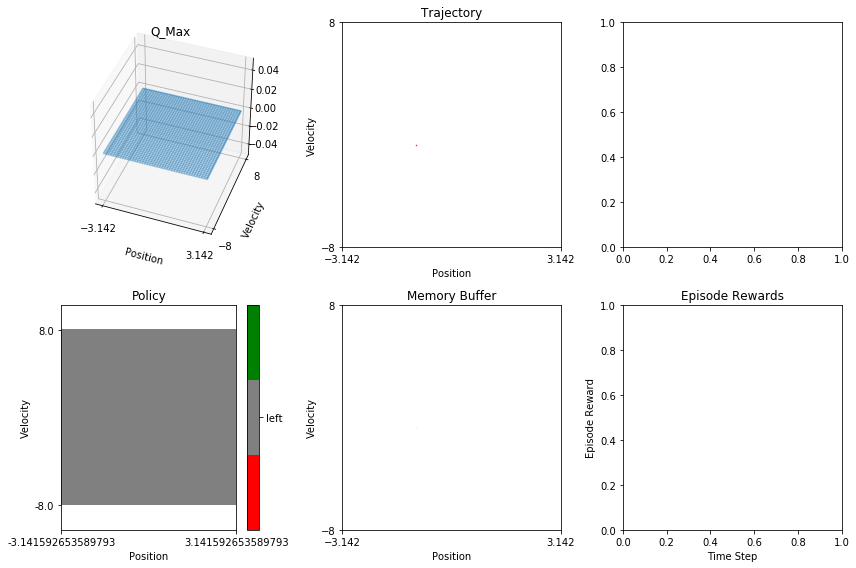

In [ ]:
experiment_pendulum_tiles_single(frames=100000000)

# Test trajectory plot

In [ ]:
env = PendulumEnv()

In [ ]:
episode_lengths = []
states = []
actions = []
rewards = []
observations = []
# env = gym.make('MountainCar-v0').env
# env = gym.make('Pendulum-v0')


In [ ]:
for e_ in range(1):
    S = env.reset();
    for t_ in itertools.count():           # count to infinity
        if t_ % 4 == 0:
            A = 1 # env.action_space.sample()     # random action
        S, R, done, O = env.step(A)
        
        # env.render()
        
        # print(env.env.state)
        
        states.append(S)
        actions.append(A)
        rewards.append(R)
        observations.append(O)
        
        # time.sleep(1)
        
        # if t_ > 3:
        #     break
        
        if done:
            episode_lengths.append(t_)
            break
    if e_ % 10 == 0:
        print(',', end='')
    else:
        print('.', end='')


In [ ]:
helpers.plot_trajectory(states, actions, env, 'MountainCar-v0', ['pos', 'vel'])

In [ ]:
theta = np.arange(-np.pi, np.pi, 0.1)

In [ ]:
observations

In [ ]:
obs_arr = np.array(observations)

In [ ]:
states

In [ ]:
conv = [(np.arctan2(s[1], s[0]), s[2]) for s in observations]

In [ ]:
conv

In [ ]:
res = np.zeros([len(states), 2])
res[range(len(res)),0] = np.arctan2(obs_arr[:,1], obs_arr[:,0])
res[range(len(res)),1] = obs_arr[:,2]
res

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot([-np.pi, np.pi], [0, 0], color='black', linewidth=0.1)
ax.plot([0, 0], [-8, 8], color='black', linewidth=0.1)
helpers.plot_trajectory(conv, actions, env, 'MountainCar-v0', ['pos', 'vel'], axis=ax)


In [ ]:
helpers.plot_trajectory(conv, actions, envp, 'MountainCar-v0', ['pos', 'vel'])

In [ ]:
helpers.plot_trajectory(conv, actions, envp, 'MountainCar-v0', ['pos', 'vel'])

# Test average episode length

In [ ]:
episode_lengths = []
states = []
actions = []
env = gym.make('MountainCar-v0').env

In [ ]:
for i in range(100):
    S = env.reset();
    for j in itertools.count():           # count to infinity
        if j % 4 == 0:
            A = env.action_space.sample()     # random action
        S, _, done, _ = env.step(A)        
        states.append(S)
        actions.append(A)
        if done:
            episode_lengths.append(j)
            break
    if i % 10 == 0:
        print(',', end='')
    else:
        print('.', end='')

In [ ]:
env.close()

In [ ]:
plt.plot(episode_lengths)
plt.plot(helpers.running_mean(episode_lengths, 1000))
plt.grid()
plt.title('OpenAI Gym Mountain Car, A*4')

In [ ]:
plt.plot(episode_lengths)
plt.plot(running_mean(episode_lengths, 1000))
plt.grid()
plt.title('OpenAI Gym Mountain Car')

---

# Function Approximators and Memory

In [1]:
class KerasFunctApprox():

    def __init__(self, model, st_low, st_high, nb_actions):
        """Q-function approximator using Keras model

        Args:
            model: Keras compiled model
        """
        st_low = np.array(st_low);    st_high = np.array(st_high)
        self._model = model
    
        first_layer = self._model.layers[0]
        nn_input_shape = first_layer.input_shape[1:]
        if st_low.shape != nn_input_shape:
            raise ValueError('Input shape does not match state_space shape')

        last_layer = self._model.layers[-1]
        nn_output_shape = last_layer.output_shape[1:]
        if (nb_actions,) != nn_output_shape:
            raise ValueError('Output shape does not match action_space shape')

        # normalise inputs
        self._offsets = st_low + (st_high - st_low) / 2
        self._scales = 1 / ((st_high - st_low) / 2)

    def eval(self, states):
        assert isinstance(states, np.ndarray)
        assert states.ndim == 2

        inputs = (states - self._offsets) * self._scales

        return self._model.predict(inputs, batch_size=len(inputs))

    def train(self, states, actions, targets):
        
        assert isinstance(states, np.ndarray)
        assert isinstance(actions, np.ndarray)
        assert isinstance(targets, np.ndarray)
        assert states.ndim == 2
        assert actions.ndim == 1
        assert targets.ndim == 1
        assert len(states) == len(actions) == len(targets)

        inputs = (states - self._offsets) * self._scales
        all_targets = self._model.predict(inputs, batch_size=len(inputs))
        all_targets[np.arange(len(all_targets)), actions] = targets
        self._model.fit(inputs, all_targets, batch_size=len(inputs), epochs=1, verbose=False)


In [2]:
class Memory:
    """Circular buffer for DQN memory reply. Fairly fast."""

    def __init__(self, max_len, state_shape, state_dtype):
        """
        Args:
            max_len: maximum capacity
        """
        assert isinstance(max_len, int)
        assert max_len > 0

        self.max_len = max_len                            # maximum length        
        self._curr_insert_ptr = 0                          # index to insert next data sample
        self._curr_len = 0                                 # number of currently stored elements

        state_arr_shape = [max_len] + list(state_shape)

        self._hist_St = np.zeros(state_arr_shape, dtype=state_dtype)
        self._hist_At = np.zeros(max_len, dtype=int)
        self._hist_Rt_1 = np.zeros(max_len, dtype=float)
        self._hist_St_1 = np.zeros(state_arr_shape, dtype=state_dtype)
        self._hist_done_1 = np.zeros(max_len, dtype=bool)

    def append(self, St, At, Rt_1, St_1, done_1):
        """Add one sample to memory, override oldest if max_len reached.

        Args:
            St [np.ndarray]   - state
            At [int]          - action
            Rt_1 [float]      - reward
            St_1 [np.ndarray] - next state
            done_1 [bool]       - next state terminal?
        """
        self._hist_St[self._curr_insert_ptr] = St
        self._hist_At[self._curr_insert_ptr] = At
        self._hist_Rt_1[self._curr_insert_ptr] = Rt_1
        self._hist_St_1[self._curr_insert_ptr] = St_1
        self._hist_done_1[self._curr_insert_ptr] = done_1
        
        if self._curr_len < self.max_len:                 # keep track of current length
            self._curr_len += 1
            
        self._curr_insert_ptr += 1                         # increment insertion pointer
        if self._curr_insert_ptr >= self.max_len:         # roll to zero if needed
            self._curr_insert_ptr = 0

    def __len__(self):
        """Number of samples in memory, 0 <= length <= max_len"""
        return self._curr_len

    def get_batch(self, batch_len):
        """Sample batch of data, with repetition

        Args:
            batch_len: nb of samples to pick

        Returns:
            states, actions, rewards, next_states, next_done, indices
            Each returned element is np.ndarray with length == batch_len
        """
        assert self._curr_len > 0
        assert batch_len > 0

        
        indices = np.random.randint(                   # randint much faster than np.random.sample
            low=0, high=self._curr_len, size=batch_len, dtype=int)

        states = np.take(self._hist_St, indices, axis=0)
        actions = np.take(self._hist_At, indices, axis=0)
        rewards_1 = np.take(self._hist_Rt_1, indices, axis=0)
        states_1 = np.take(self._hist_St_1, indices, axis=0)
        dones_1 = np.take(self._hist_done_1, indices, axis=0)

        return states, actions, rewards_1, states_1, dones_1, indices


    
    def pick_last(self, nb):
        """Pick last nb elements from memory
        
        Returns:
            states, actions, rewards, next_states, done_1, indices
            Each returned element is np.ndarray with length == batch_len
        """
        assert nb <= self._curr_len
        
        start = self._curr_insert_ptr - nb                # inclusive
        end = self._curr_insert_ptr                       # not inclusive
        indices = np.array(range(start,end), dtype=int)   # indices to pick, can be negative
        indices[indices < 0] += self._curr_len            # loop negative to positive
        
        states = np.take(self._hist_St, indices, axis=0)
        actions = np.take(self._hist_At, indices, axis=0)
        rewards_1 = np.take(self._hist_Rt_1, indices, axis=0)
        states_1 = np.take(self._hist_St_1, indices, axis=0)
        dones_1 = np.take(self._hist_done_1, indices, axis=0)
        
        return states, actions, rewards_1, states_1, dones_1, indices
    